In [107]:
import torch
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import codecs
import re

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [108]:
df = pd.read_csv('/kaggle/input/cbd-dataset/cleaned_dataset.csv')
df.head()

,Unnamed: 0,id,comment,lable,Text_cleaned
0,0,1,@USER @USER අනේ බන් ප්ලෙන්ටියක් බොන්න සල්ලි නෑ...,Hate speech,අනේ බන් ප්ලෙන්ටියක් බොන්න සල්ලි නෑ හුත්ත
1,1,2,"""RT @randeera: කවුරු මොනා කිවුවත් පොඩ්ඩක් කියල...",Neutral,කවුරු මොනා කිවුවත් පොඩ්ඩක් කියලා බලපන් පල්ලියක...
2,2,3,කාලකන්නි බල්ලො,Hate speech,කාලකන්නි බල්ලො
3,3,4,පොලූ කනකොට ඔහොම තමයි,Hate speech,පොලූ කනකොට ඔහොම තමයි
4,4,5,පොට්ට වේසි- යුද්දෙන් 3/4 ක් ඉවර කලේ මම (චන්ද්‍...,Hate speech,පොට්ට වේසි යුද්දෙන් ක් ඉවර කලේ මම චන්ද්‍රිකා ...


In [109]:
category_count = df['lable'].value_counts()

categories = category_count.index

categories

Index(['Hate speech', 'Neutral', 'Sexism', 'Racist'], dtype='object')

In [110]:
# categories = df[['lable']].values.reshape(-1)

# counter_categories = Counter(categories)
# category_names = counter_categories.keys()
# category_values = counter_categories.values()

# y_pos = np.arange(len(category_names))

# plt.figure(1, figsize=(10, 5))
# plt.bar(y_pos, category_values, align='center', alpha=0.5)
# plt.xticks(y_pos, category_names)
# plt.ylabel('Number of texts')
# plt.title('Distribution of texts per category')
# plt.gca().yaxis.grid(True)
# plt.show()

# print(counter_categories)

In [111]:
# def calculate_stats(df, split_char=' '):
#     categories = df['lable'].unique()
    
#     all_lengths = []
#     per_category = {
#         'lengths': {c:[] for c in categories},
#         'mean': {c:0 for c in categories},
#         'stdev': {c:0 for c in categories}
#     }

#     for index, row in df.iterrows():
#         text = row['Text_cleaned']
#         text = re.sub(r"\s+", ' ', text) # Normalize
#         text = text.split(split_char)
#         l = len(text)
        
#         category = row['lable']
        
#         all_lengths.append(l)
#         per_category['lengths'][category].append(l)
    
#     for c in categories:
#         per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
#         per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
#     global_stats = {
#         'mean': statistics.mean(all_lengths),
#         'stdev': statistics.stdev(all_lengths),
#         'lengths': all_lengths
#     }
    
#     return {
#         'global': global_stats,
#         'per_category': pd.DataFrame(per_category)
#     }


# def display_lengths_histograms(df_stats, n_cols=3):
#     categories = df['lable'].unique()
#     n_rows = math.ceil(len(categories) / n_cols)
    
#     plt.figure(figsize=(15, 8))
#     plt.suptitle('Distribution of lengths')
    
#     # Subplot of all lengths
#     plt.subplot(n_rows, n_cols, 1)
#     plt.title('All categories')
#     lengths = df_stats['global']['lengths']
#     plt.hist(lengths, color='r')

#     # Subplot of each category
#     index_subplot = 2
#     for c in categories:
#         plt.subplot(n_rows, n_cols, index_subplot)
#         plt.title('Category: %s' % c)
        
#         lengths = df_stats['per_category']['lengths'][c]
#         plt.hist(lengths, color='b')

#         index_subplot += 1

#     plt.show()

In [112]:
# df_stats = calculate_stats(df)
# df_stats['per_category']

In [113]:
# display_lengths_histograms(df_stats)

In [114]:
# n_texts = len(X_data)
# print('Texts in dataset: %d' % n_texts)

# categories = df['lable'].unique()
# n_categories = len(categories)
# print('Number of categories: %d' % n_categories)

In [115]:
possible_labels = df.lable.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Hate speech': 0, 'Neutral': 1, 'Sexism': 2, 'Racist': 3}

In [116]:
df['value_lable'] = df.lable.replace(label_dict)

In [117]:
from sklearn.model_selection import train_test_split

In [118]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.value_lable.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.value_lable.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['lable', 'value_lable', 'data_type']).count()


Unnamed: 0    id  comment  Text_cleaned
lable       value_lable data_type                                         
Hate speech 0           train            1138  1138     1138          1138
                        val               201   201      201           201
Neutral     1           train            1052  1052     1052          1052
                        val               186   186      186           186
Racist      3           train             881   881      881           881
                        val               155   155      155           155
Sexism      2           train             889   889      889           889
                        val               157   157      157           157

In [119]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Text_cleaned.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Text_cleaned.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2352: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [120]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].value_lable.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].value_lable.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [121]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [122]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [123]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [124]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [125]:
import os

# Create the directory 'data_volume' if it does not already exist
if not os.path.exists('data_volume'):
    os.makedirs('data_volume')

import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [134]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

import random
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels':         batch[2].to(device),
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
model.to(device)

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels':         batch[2].to(device),
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/248 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.3495861104419153
Validation loss: 1.34909987449646
F1 Score (Weighted): 0.2506290845993313


Epoch 2:   0%|          | 0/248 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.3307058796767266
Validation loss: 1.3335712226954373
F1 Score (Weighted): 0.284363567734487


Epoch 3:   0%|          | 0/248 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.319238501691049
Validation loss: 1.3278703120621769
F1 Score (Weighted): 0.30203100227468066


Epoch 4:   0%|          | 0/248 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.3024231409353595
Validation loss: 1.3144480978900737
F1 Score (Weighted): 0.3374806044698076


Epoch 5:   0%|          | 0/248 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.294513325056722
Validation loss: 1.3137548471038991
F1 Score (Weighted): 0.31995552185821136


Epoch 6:   0%|          | 0/248 [00:00<?, ?it/s]


Epoch 6
Training loss: 1.2839205870705266
Validation loss: 1.3176372024145993
F1 Score (Weighted): 0.32100452057411966


Epoch 7:   0%|          | 0/248 [00:00<?, ?it/s]


Epoch 7
Training loss: 1.2711385531771568
Validation loss: 1.313398079438643
F1 Score (Weighted): 0.3437462471761924


Epoch 8:   0%|          | 0/248 [00:00<?, ?it/s]


Epoch 8
Training loss: 1.2603423196461894
Validation loss: 1.3137174980206923
F1 Score (Weighted): 0.32600339608715195


Epoch 9:   0%|          | 0/248 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [135]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_2.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: Hate speech
Accuracy: 75/201

Class: Neutral
Accuracy: 50/186

Class: Sexism
Accuracy: 0/157

Class: Racist
Accuracy: 112/155



NameError: name 'history' is not defined

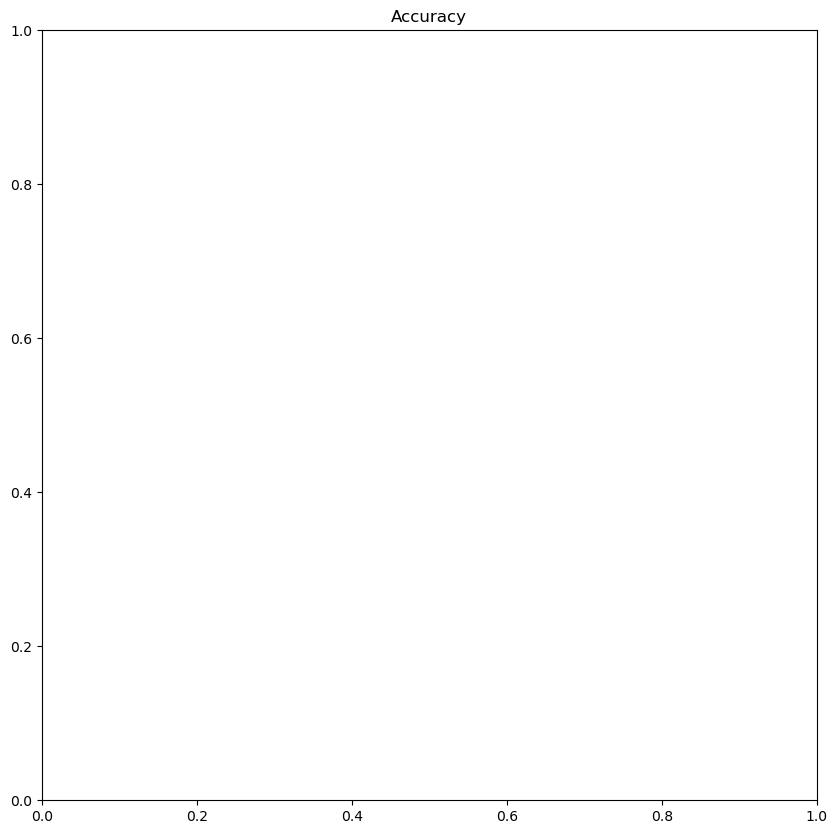

In [136]:
# plt.figure(figsize=(10, 10))
# plt.title('Accuracy')

# xaxis = np.arange(len(history.history['accuracy']))
# plt.plot(xaxis, history.history['accuracy'], label='Train set')
# plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
# plt.legend()

In [ ]:
# def plot_confusion_matrix(X_test, y_test, model):
#     y_pred = model.predict(X_test)
#     y_pred = [np.argmax(i) for i in model.predict(X_test)]

#     con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

#     con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
#     label_names = list(range(len(con_mat_norm)))

#     con_mat_df = pd.DataFrame(con_mat_norm,
#                               index=label_names, 
#                               columns=label_names)

#     figure = plt.figure(figsize=(10, 10))
#     sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [ ]:
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1] * 100))

In [ ]:
# plot_confusion_matrix(X_test, y_test, model)